## Importieren der Bibliotheken

In [51]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from skopt import BayesSearchCV

## Dateien laden

In [52]:
# Pfad zu den Daten
DATA_DIR = Path('Dataset Competition')

In [53]:
# Einlesen der Daten
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

## Tranformieren der Daten



In [54]:
# One-Hot-Encoding
train_values = pd.get_dummies(train_values)

## Trainings und Validierungsdaten erstellen

In [55]:
# Aufteilen der Daten in Trainings- und Validierungsdaten, 80% Trainingsdaten, 20% Validierungsdaten
train_values, validation_values, train_labels, validation_labels = train_test_split(train_values, train_labels, test_size=0.2, random_state=42)


## Ausreißer entfernen
(nicht genutzt)

In [26]:
# # Entfernen von Ausreißern in age Variable
# variable = 'age'
# threshold =  250

# # Entferne alle Zeilen, in denen der Wert in der Spalte 'age' den 'threshold' überschreitet
# filtered_train_values = train_values[train_values[variable] <= threshold]

# # Entferne die gleichen Zeilen aus dem Label-Datensatz
# filtered_train_labels = train_labels[train_labels.index.isin(filtered_train_values.index)]

## SMOTE anwenden
(nicht genutzt)

In [27]:
# # SMOTE anwenden
# sm = SMOTE(random_state=42)
# train_values_smote, train_labels_smote = sm.fit_resample(train_values, train_labels.values.ravel())

## Pipeline erstellen

In [56]:
# Pipeline erstellen aus Preprocessing und Modell
pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=2018, n_estimators=1000, max_depth=50, max_features=39, min_samples_leaf=1, min_samples_split=27))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=50, max_features=39,
                                        min_samples_split=27, n_estimators=1000,
                                        random_state=2018))])

## Hyperparameter tuning mit Grid Search
(nicht genutzt)

In [30]:
# param_grid = {'randomforestclassifier__n_estimators': [100, 250, 500, 1000],
#             'randomforestclassifier__min_samples_leaf': [1, 2, 4],
#             'randomforestclassifier__max_features': [20, 25, 30, 35, 40],
#             'randomforestclassifier__max_depth': [10, 25, 50],
#             'randomforestclassifier__min_samples_split': [20, 25, 30, 35],
#             'randomforestclassifier__criterion': ['gini', 'entropy'],}
# gs = GridSearchCV(pipe, param_grid, cv=5)

## Hyperparameter tuning mit Randomized Search
(nicht genutzt)

In [31]:
# from scipy.stats import randint

# param_dist = {'randomforestclassifier__n_estimators': randint(50,500),
#               'randomforestclassifier__min_samples_leaf': randint(1,10)}


# # Use random search to find the best hyperparameters
# rs = RandomizedSearchCV(pipe, 
#                                  param_distributions = param_dist, 
#                                  n_iter=10, 
#                                  cv=5)

## Sequential Model-Based Optimization (SMBO)
(Ausführung dauert einige Stunden)

In [36]:
opt = BayesSearchCV(
    pipe,
    {
    'randomforestclassifier__n_estimators': (100, 1000),
    'randomforestclassifier__max_depth': (1, 50),
    'randomforestclassifier__min_samples_split': (2, 100),
    'randomforestclassifier__min_samples_leaf': (1, 50),
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': (20, 39)
    },
    n_iter=32,
    cv=3,
    scoring=make_scorer(f1_score, average='micro'), 
    random_state=123
)

# Modell auf Trainingsdaten anpassen
np.int = int
opt.fit(train_values, train_labels.values.ravel())

# Ergebnisse ausgeben
print("Validation score: %s" % opt.best_score_)
print("Test score: %s" % opt.score(validation_values, validation_labels.values.ravel()))
print("Best parameters: %s" % str(opt.best_params_))

Validation score: 0.7352551811691187
Test score: 0.7390303332629842
Best parameters: OrderedDict({'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__max_features': 39, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 27, 'randomforestclassifier__n_estimators': 1000})


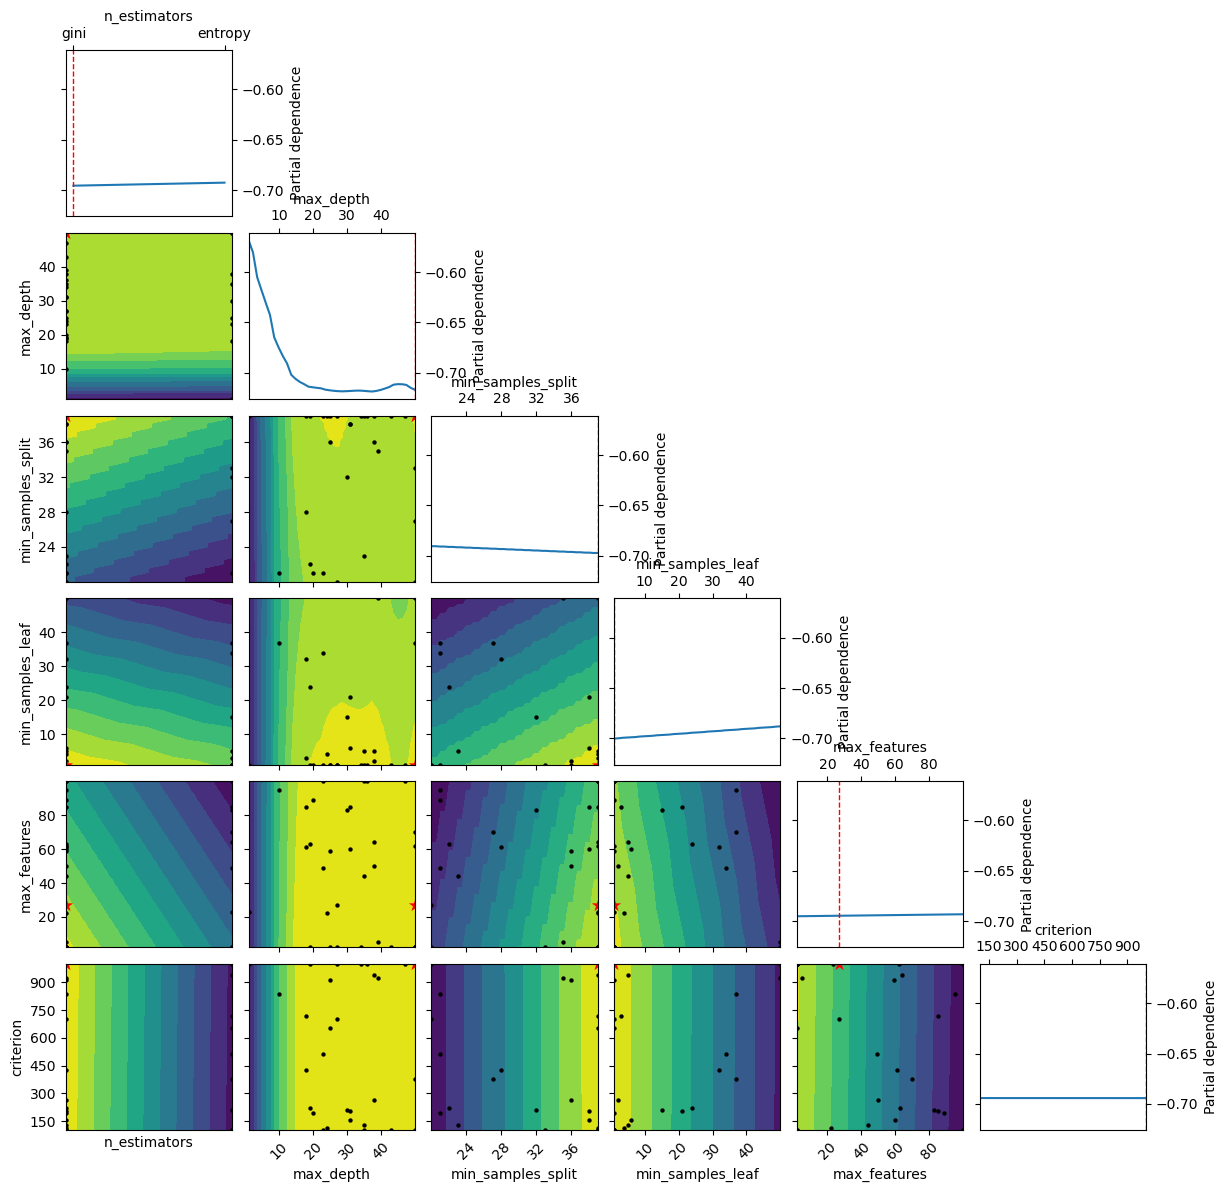

In [38]:
from skopt.plots import plot_objective, plot_histogram
_ = plot_objective(opt.optimizer_results_[0],
                   dimensions=["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "max_features", "criterion"],)
plt.show()

## Modell erstellen

In [57]:
rf_model = pipe.fit(train_values, train_labels.values.ravel())


## Vorhersagen erstellen

In [58]:
val_preds = rf_model.predict(validation_values)
# F1-Score berechnen
print(f1_score(validation_labels, val_preds, average='micro'))

0.7390303332629842


## Feature Wichtigkeit

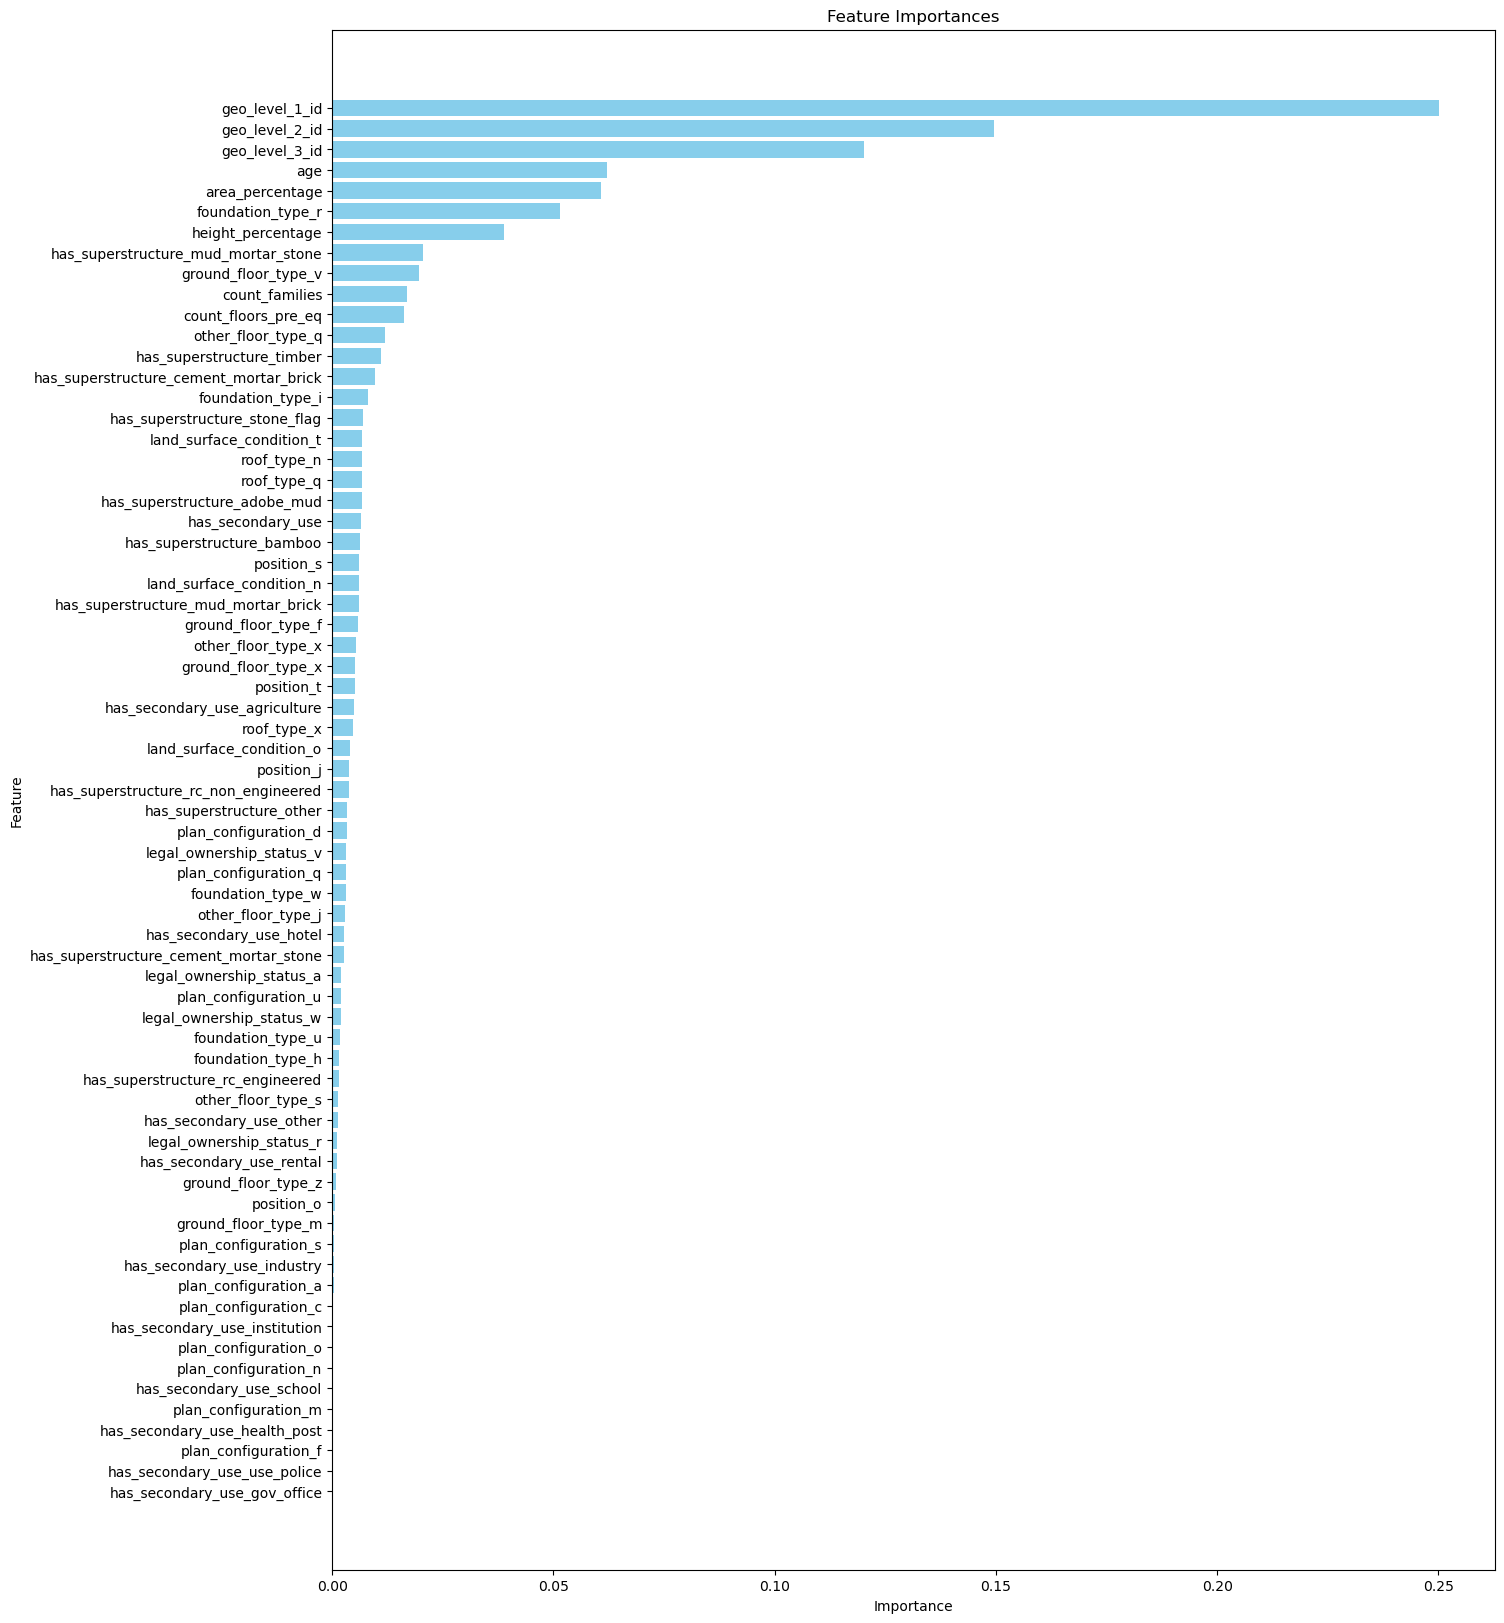

In [59]:
# Feature Wichtigkeiten
importances = rf_model.named_steps['randomforestclassifier'].feature_importances_
features_df = pd.DataFrame({
    'Feature': train_values.columns,
    'Importance': importances
})
# Sortieren der Werte nach Wichtigkeit
features_df = features_df.sort_values('Importance', ascending=False)

# Erstellen des Plots
plt.figure(figsize=(15, 20))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Um die wichtigsten Features oben anzuzeigen
plt.show()

## Konfusionsmatrix erstellen

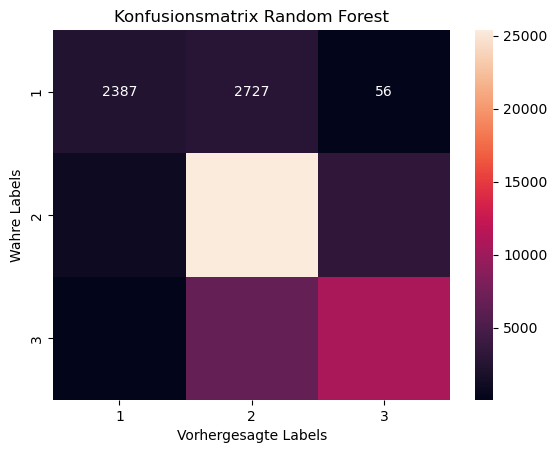

In [60]:
cm = confusion_matrix(validation_labels, val_preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Konfusionsmatrix Random Forest')
plt.show()

## Submission erstellen

In [ ]:
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')
test_values = pd.get_dummies(test_values)
predictions = rf_model.predict(test_values)
submission_format = pd.read_csv(DATA_DIR / 'submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)   

my_submission.head()
my_submission.to_csv('submission_rf.csv')